In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [2]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
import tensorflow.keras.backend as K

In [3]:
archs = np.array([[-1,-1],
                  [2,-2],
#                   [4,6],
                  [-2,2]])

In [4]:
X,Y = archs.T

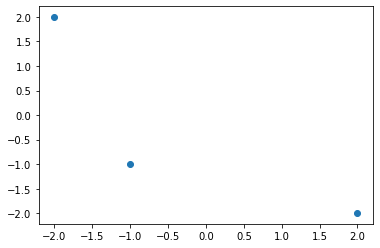

In [5]:
plt.scatter(X,Y)

In [6]:
def generate_data (archs, n_points, noise=0.1):
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    return data

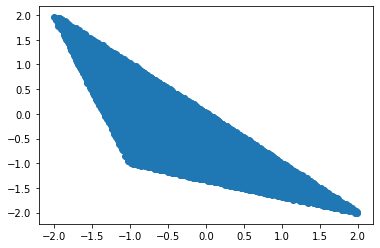

In [7]:
x_train = generate_data (archs,100000,noise=0.01)
x_test = generate_data (archs,10000,noise=0.01)

dataX,dataY = x_train.T
plt.scatter(dataX,dataY)

In [8]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim),stddev=0.1)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [9]:
def A_Zfixed_prod ( A ):

    dim_latent_space = A.get_shape().as_list()[1] - 1

    z_fixed_t = np.zeros([dim_latent_space, dim_latent_space + 1])

    for k in range(0, dim_latent_space):
        s = 0.0
        for i in range(0, k):
            s = s + z_fixed_t[i, k] ** 2
  
        z_fixed_t[k, k] = np.sqrt(1.0 - s)

        for j in range(k + 1, dim_latent_space + 1):
            s = 0.0
            for i in range(0, k):
                s = s + z_fixed_t[i, k] * z_fixed_t[i, j]

            z_fixed_t[k, j] = (-1.0 / float(dim_latent_space) - s) / z_fixed_t[k, k]
            z_fixed = np.transpose(z_fixed_t)
                
    z_fixed_tens = K.constant(z_fixed)
    
    return K.dot (A,z_fixed_tens)
    

In [ ]:
original_dim = x_train.shape[1]
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

# network parameters
input_shape = (original_dim, )
intermediate_dim = 64
batch_size = 256
latent_dim = 2
simplex_vrtxs = latent_dim + 1
epochs = 20

inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
A = Dense (simplex_vrtxs, activation=K.softmax)(x)

mu = Lambda (A_Zfixed_prod, output_shape=(latent_dim,), name='mu' )(A)

# B_t = Dense (simplex_vrtxs)(encoded_input)
# B = tf.nn.softmax(tf.transpose(weights_B_t), axis=1)
# z_pred = tf.matmul(B,mu)

sigma = Dense(latent_dim, activation=K.softplus)(x)
t = Lambda(sampling, output_shape=(latent_dim,), name='t')([mu, sigma])

encoder = Model(inputs, [t,mu,sigma], name='encoder')
encoder.summary()

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='linear')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[0])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(inputs, outputs)

kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
beta = 0.1
vae_loss = K.mean(reconstruction_loss + beta*kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train, y=None,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           192         encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            195         dense_1[0][0]                    
__________________________________________________________________________________________________
mu (Lambda)                     (None, 2)            0           dense_2[0][0]                    
____________________________________________________________________________________________

/home/sbailo/anaconda3/envs/archetypes/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 2s 25us/step - loss: 0.1362 - val_loss: 0.0617
Epoch 2/20
 91648/100000 [==========================>...] - ETA: 0s - loss: 0.0549

In [ ]:
x_pred = encoder.predict(x_train)
dataX,dataY = x_pred[0].T
plt.scatter(dataX,dataY)


In [ ]:
x_pred = encoder.predict(x_train)
dataX,dataY = x_pred[1].T
plt.scatter(dataX,dataY)


In [ ]:
x_pred = encoder.predict(x_train)
dataX,dataY = x_pred[2].T
plt.scatter(dataX,dataY)


In [ ]:
x_pred = vae.predict(x_train)
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY)


In [ ]:
x_pred = vae.predict(x_test)
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY)
